# Refactoring Code with Artifacts

Data science development is characterized by nimble, iterative experimentation and exploratory data analysis.
Data scientists explore many possibilities before reaching the final result. The rapid exploration process often
leads to long, messy code, the majority of which has no impact on the final result.

Code refactoring is hence an essential step for moving data science work into production. Yet, it often becomes a major bottleneck as it involves manual inspection of long, messy code that sometimes does not make sense even to its own author. With the complete development history stored in artifacts, LineaPy enables automatic code clean-up,
facilitating code refactoring and hence transition to production.

In this tutorial, we will walk through an example that illustrates how this can be done.

<div class="alert alert-info">

You can ignore `# NBVAL_*` comments in certain cell blocks. They are for passing unit tests only, which we do to make sure the examples are always functional as we update the codebase.

</div>

In [1]:
# NBVAL_IGNORE_OUTPUT

import os
import lineapy
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

lineapy.options.set("is_demo", True) # Not for normal use

We were given a data set to explore. Let's see what it contains.

In [2]:
# NBVAL_IGNORE_OUTPUT

# Load data
df = pd.read_csv("https://raw.githubusercontent.com/LineaLabs/lineapy/main/examples/tutorials/data/iris.csv")

In [3]:
# View data
df

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


It is simple data that contains different iris species and their physical measurements. Our common sense dictates that petal and sepal traits may have an association. Let's quickly check.

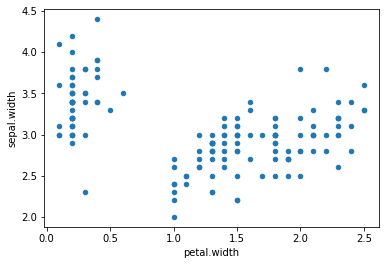

In [4]:
# Plot petal vs. sepal width
df.plot.scatter("petal.width", "sepal.width")
plt.show()

Interestingly, we observe what appears to be an inverse relationship between petal and sepal widths. That is, the wider an iris's petal is, the narrower its sepal is.

Can we quantify this relationship? We can check correlation coefficient:

In [5]:
# Calculate correlation coefficient
df[["petal.width", "sepal.width"]].corr(method="pearson")

,petal.width,sepal.width
petal.width,1.000000,-0.366126
sepal.width,-0.366126,1.000000


The value confirms our visual observation: petal and sepal widths are negatively correlated.

To make our analysis more interesting, let’s try some formal modeling. We can start with linear regression.

In [6]:
# Initiate the model
lm_1 = LinearRegression()

# Fit the model
lm_1.fit(
    X=df[["petal.width"]],
    y=df["sepal.width"],
)

LinearRegression()

In [7]:
# NBVAL_IGNORE_OUTPUT

# Check result
print(f"Coefficient for petal.width: {lm_1.coef_[0]}")

Coefficient for petal.width: -0.20935983162745503


Result suggests that a unit increase in petal width is associated with about a 0.2 unit decrease in sepal width.

Now, we may wonder if species plays any role in this. That is, given the same iris type, how is change in petal width associated with change in sepal width?

To answer this question, we can include the species terms in our regression model. But we need to first pre-process the data. Specifically, `variety` needs to be transformed into a set of numeric variables so that the model can use the information. Let's have Setosa as the baseline category.

In [8]:
# Check species and their counts
df["variety"].value_counts()

Setosa        50
Versicolor    50
Virginica     50
Name: variety, dtype: int64

In [9]:
# Create dummy variables encoding species
df["d_versicolor"] = df["variety"].apply(lambda x: 1 if x == "Versicolor" else 0)
df["d_virginica"] = df["variety"].apply(lambda x: 1 if x == "Virginica" else 0)

In [10]:
# View data
df

,sepal.length,sepal.width,petal.length,petal.width,variety,d_versicolor,d_virginica
0,5.1,3.5,1.4,0.2,Setosa,0,0
1,4.9,3.0,1.4,0.2,Setosa,0,0
2,4.7,3.2,1.3,0.2,Setosa,0,0
3,4.6,3.1,1.5,0.2,Setosa,0,0
4,5.0,3.6,1.4,0.2,Setosa,0,0
...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica,0,1
146,6.3,2.5,5.0,1.9,Virginica,0,1
147,6.5,3.0,5.2,2.0,Virginica,0,1
148,6.2,3.4,5.4,2.3,Virginica,0,1


And we train another model using the new species terms:

In [11]:
# Initiate the model
lm_2 = LinearRegression()

# Fit the model
lm_2.fit(
    X=df[["petal.width", "d_versicolor", "d_virginica"]],
    y=df["sepal.width"],
)

LinearRegression()

In [12]:
# NBVAL_IGNORE_OUTPUT

# Check result
print(f"Coefficient for petal.width: {lm_2.coef_[0]}")
print(f"Coefficient for d_versicolor: {lm_2.coef_[1]}")
print(f"Coefficient for d_virginica: {lm_2.coef_[2]}")

Coefficient for petal.width: 0.781015495565735
Coefficient for d_versicolor: -1.5014967352109916
Coefficient for d_virginica: -1.8442075821070065


Interestingly, we now get a positive coefficient value for petal width! That is, controlling for the iris type, a petal width has a positive association with sepal width. What we observed earlier is a spurious association due to the confounding effect of species.

Let's revisit the scatter plot noting each species:

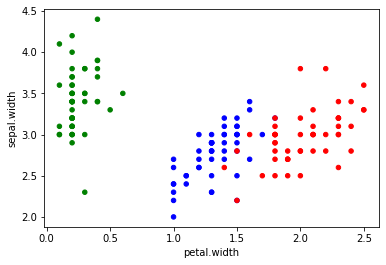

In [13]:
# Map each species to a color
color_map = {"Setosa": "green", "Versicolor": "blue", "Virginica": "red"}
df["variety_color"] = df["variety"].map(color_map)

# Plot petal vs. sepal width by species
df.plot.scatter("petal.width", "sepal.width", c="variety_color")
plt.show()

We visually confirm that, within each species, petal and sepal widths have a positive association.

Let's take a step further: given what appears to be an ambiguous association for Setosa in the plot above, we may wonder if species also mediates the association itself. That is, is it possible that the association between petal and sepal widths differs by species? To examine this possibility, we can introduce interaction terms.

In [14]:
# Create interaction terms for species
df["i_versicolor"] = df["petal.width"] * df["d_versicolor"]
df["i_virginica"] = df["petal.width"] * df["d_virginica"]

In [15]:
# Initiate the model
lm_3 = LinearRegression()

# Fit the model
lm_3.fit(
    X=df[["petal.width", "d_versicolor", "d_virginica", "i_versicolor", "i_virginica"]],
    y=df["sepal.width"],
)

LinearRegression()

In [16]:
# NBVAL_IGNORE_OUTPUT

# Check result
print(f"Coefficient for petal.width: {lm_3.coef_[0]}")
print(f"Coefficient for d_versicolor: {lm_3.coef_[1]}")
print(f"Coefficient for d_virginica: {lm_3.coef_[2]}")
print(f"Coefficient for i_versicolor: {lm_3.coef_[3]}")
print(f"Coefficient for i_virginica: {lm_3.coef_[4]}")

Coefficient for petal.width: 0.8371922087467842
Coefficient for d_versicolor: -1.849187758710705
Coefficient for d_virginica: -1.5272777065297922
Coefficient for i_versicolor: 0.21645563594583703
Coefficient for i_virginica: -0.20578698175690244


The model still suggests a positive association between petal and sepal widths *accounting for interaction effect of species*.

Now, we are ready to wrap up our analysis. Say we decided that we would later revisit our second model (`lm_2`). We can then store it as an artifact, like so:

In [17]:
# Save model as an artifact
artifact = lineapy.save(lm_2, "linear_model_v2")

If we print the artifact’s code, we get:

In [18]:
# Get cleaned-up code
print(artifact.get_code())

import pandas as pd
from sklearn.linear_model import LinearRegression

df = pd.read_csv(
    "https://raw.githubusercontent.com/LineaLabs/lineapy/main/examples/tutorials/data/iris.csv"
)
df["d_versicolor"] = df["variety"].apply(lambda x: 1 if x == "Versicolor" else 0)
df["d_virginica"] = df["variety"].apply(lambda x: 1 if x == "Virginica" else 0)
lm_2 = LinearRegression()
lm_2.fit(
    X=df[["petal.width", "d_versicolor", "d_virginica"]],
    y=df["sepal.width"],
)



which is more concise and manageable than what we have generated &mdash; a long, messy collection of various operations.

In practice, development scripts/notebooks by data scientists are much longer and more complicated than the current example. Hence, LineaPy's automatic code refactoring can save considerable time for data scientists and production engineers.

Note that this clean-up does not mean that we lost other parts of the development code. We can still access the artifact's full session code (including comments), like so:

In [19]:
# Get full code
print(artifact.get_session_code())

# NBVAL_IGNORE_OUTPUT

import os
import lineapy
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
# NBVAL_IGNORE_OUTPUT

# Load data
df = pd.read_csv("https://raw.githubusercontent.com/LineaLabs/lineapy/main/examples/tutorials/data/iris.csv")
# View data
df
# Plot petal vs. sepal width
df.plot.scatter("petal.width", "sepal.width")
plt.show()
# Calculate correlation coefficient
df[["petal.width", "sepal.width"]].corr(method="pearson")
# Initiate the model
lm_1 = LinearRegression()

# Fit the model
lm_1.fit(
    X=df[["petal.width"]],
    y=df["sepal.width"],
)
# NBVAL_IGNORE_OUTPUT

# Check result
print(f"Coefficient for petal.width: {lm_1.coef_[0]}")
# Check species and their counts
df["variety"].value_counts()
# Create dummy variables encoding species
df["d_versicolor"] = df["variety"].apply(lambda x: 1 if x == "Versicolor" else 0)
df["d_virginica"] = df["variety"].apply(lambda x: 1 if x == "Virginica" else 0)
# View data
df
# Initia

This should come in handy when trying to remember or understand the original development context of a given artifact.